In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 7

import os
from pprint import pprint
from copy import deepcopy

# Investigtion into Cases of Dengue in the Philippines

## 1. Understanding and Applications

In [3]:
from IPython.display import Image
from IPython.core.display import HTML

Image(url='http://www.philippines-travel-guide.com/images/xpi-map.jpg.pagespeed.ic.PhvJv6GE2h.jpg')

This dataset contains information on 8 years of the cases of dengue fever in the Philippines

## 2. Analysis

In [4]:
file_dir = os.path.join(os.pardir, 'data', 'denguecases.csv')

dengue_df = pd.read_csv(file_dir)
dengue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 4 columns):
Month           1836 non-null object
Year            1836 non-null int64
Region          1836 non-null object
Dengue_Cases    1836 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 57.5+ KB


In [5]:
months = {'Jan': 1,
          'Feb': 2,
          'Mar': 3,
          'Apr': 4,
          'May': 5,
          'Jun': 6,
          'Jul': 7,
          'Aug': 8,
          'Sep': 9,
          'Oct': 10,
          'Nov': 11,
          'Dec': 12
         }

# want to convert months to 
def month_to_num(month):
    if month in months.keys():
        return months[month]
    else:
        return month

In [6]:
def group_heatmap(data, y_hat, group_feature, error=False):
    if 'Dengue_Cases' not in data.columns:
        data_m = data.filter(['Region', group_feature]).merge(pd.DataFrame(y_hat), right_index=True, left_index=True, sort=False)
    else:
        data_m = data.filter(['Region', group_feature, 'Dengue_Cases'], axis=1)
    groups = data_m.groupby([group_feature, 'Region'], sort=False)
    group_sum = groups.sum().unstack(level=0)
    sns.heatmap(group_sum, cmap='Reds')

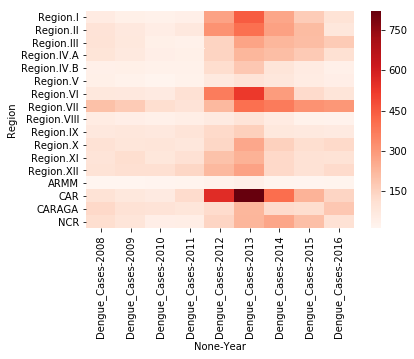

In [7]:
group_heatmap(dengue_df.drop('Dengue_Cases', axis=1), dengue_df.Dengue_Cases, 'Year')

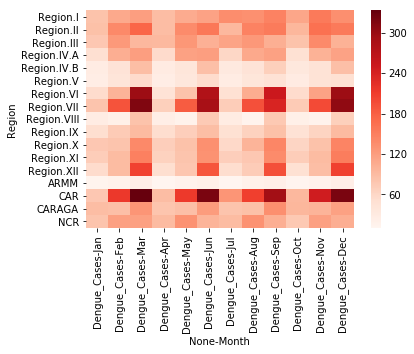

In [8]:
group_heatmap(dengue_df.drop('Dengue_Cases', axis=1), dengue_df.Dengue_Cases, 'Month')

This gives us an interesting view of what features may be important and which features we may need to engineer. Clearly, region is going to be important. Also, absolute month matters a lot, as there appears to be an extremely predictable four-season cycle of disease intensity.

Unlike months, however, the absolute year is unlikely to tell us much at all (What does 2008 data have to do with 2016 data?). However, we could do something like adding features for how many confirmed cases were in the year or two previous. Additionally, it may be useful to keep data on the past month or two. This may cause awkwardness around the start of the data, and we may have to decide whether to throw out the early data or just assume that any earlier data was 0 or the mean over years or some other standard setting.

In [821]:
# one-hot encode the Region and Month variables

dengue_one_hot = pd.concat([dengue_df.drop(['Region', 'Year', 'Month'], axis=1), # dropping year because it's unnecessary
                            pd.get_dummies(dengue_df.Region), 
                            pd.get_dummies(dengue_df.Month)],
                          axis=1)
dengue_one_hot.head()

,Dengue_Cases,ARMM,CAR,CARAGA,NCR,Region.I,Region.II,Region.III,Region.IV.A,Region.IV.B,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,2.953926,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2.183336,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0.972410,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,9.357156,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7.320599,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [823]:
# adding features to take into account knowledge of the past
dengue_one_hot['Past_Year'] = None
dengue_one_hot['Past_Month'] = None
dengue_one_hot['Two_Months'] = None
dengue_one_hot['Three_Months'] = None

# Here, we will try imputing everything beyond our window of knowledge as being the mean of the confirmed cases. This will almost certainly be tweaked later to find a better method

for idx in dengue_one_hot.index:
    dengue_one_hot.loc[idx, 'Past_Year'] = dengue_one_hot.loc[idx-12, 'Dengue_Cases'].astype(np.float64) if idx >=12 else dengue_one_hot['Dengue_Cases'].mean()
    dengue_one_hot.loc[idx, 'Past_Month'] = dengue_one_hot.loc[idx-1, 'Dengue_Cases'].astype(np.float64) if idx >= 1 else dengue_one_hot['Dengue_Cases'].mean()
    dengue_one_hot.loc[idx, 'Two_Months'] = dengue_one_hot.loc[idx-2, 'Dengue_Cases'].astype(np.float64) if idx >= 2 else dengue_one_hot['Dengue_Cases'].mean()
    dengue_one_hot.loc[idx, 'Three_Months'] = dengue_one_hot.loc[idx-3, 'Dengue_Cases'].astype(np.float64) if idx >= 3 else dengue_one_hot['Dengue_Cases'].mean()
    

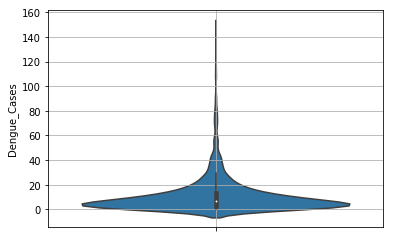

In [824]:
sns.violinplot(data=dengue_df, y='Dengue_Cases')
plt.grid()

In [825]:
dengue_features = dengue_one_hot.drop('Dengue_Cases', axis=1).astype(np.float64)
dengue_cases = dengue_one_hot.Dengue_Cases

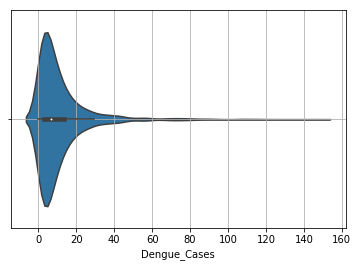

In [826]:
sns.violinplot(dengue_cases)
plt.grid()

In [827]:
dengue_target = pd.cut(dengue_cases, [-0.1, 3.0, 11.3, 45.0, 1e6], 
                       labels=[0, 1, 2, 3]).astype(np.float64)

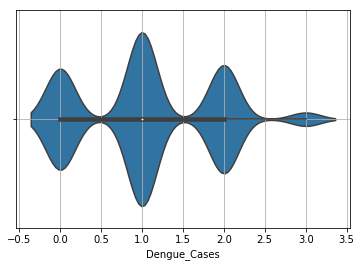

In [828]:
sns.violinplot(dengue_target)
plt.grid()

## Custom Logistic Regression Model

### Building the Model

Class Structure:
- BinaryLogisticRegressionBase
  - BinaryLogisticRegression
- LogisticRegressionBase
  - LogisticRegression
  
LogisticRegression will instantiate $n$ Binary Regression Objects, where $n$ is the number of classes that we are distinguishing between.

The Binary Logistic Regression model will have options for setting l1- and l2-norm regularization, as well as an option for choosing optimization strategies (e.g. batch, SGD, BFGS).

In [907]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error

In [829]:
from scipy.special import expit

class BinaryLogisticRegressionBase:
    
    '''Implements binary logistic regression for '''
    
    def __init__(self,
                alpha=0.1,
                threshold=0.5,
                iterations=500,
                C=0.1,
                reg='l2',
                tol=1e-3,
                solver='bfgs'
               ):
        self.alpha = np.float64(alpha)
        self.max_it = np.int(iterations)
        self.tol = np.float64(tol)
        self.C = np.float64(C)
        self.threshold = np.float64(threshold)
        
        if solver not in ['batch', 'stochastic', 'bfgs']:
            raise ValueError('That is not a valid value for solver.')
        else:
            self.solver = solver
        
        if reg not in ['l1', 'l2', 'l1_and_l2']:
            raise ValueError('That is not a valid value for reg.')
        else:
            self.reg = reg
        
    @staticmethod
    def _sigmoid(theta):
        return 1/(1 + np.exp(-theta))
    
    @staticmethod
    def _add_bias(X):
        return np.hstack([np.ones((X.shape[0], 1)), X])
    
    def _regularize(self):
        if self.reg == 'l1':
            return np.sum(self.w_/abs(self.w_))
            
        elif self.reg == 'l2':
            return 2 * np.sum(self.w_)
            
        elif self.reg == 'l1_and_l2':
            return np.sum(self.w_/abs(self.w_)) + 2 * np.sum(self.w_)
        else:
            raise ValueError('Somehow, this object has come to have a bad value for the \'reg\' attribute.')        

    def predict_proba(self, X, add_bias=True):
        return (expit(self._add_bias(X) @ self.w_) if add_bias else expit(X @ self.w_))
        
    def predict(self, X):
        return (self.predict_proba(X) > self.threshold).astype(np.int)

In [920]:
from scipy.optimize import fmin_bfgs

class BinaryLogisticRegression(BinaryLogisticRegressionBase):

    def __init__(self,
                alpha=0.1,
                threshold=0.5,
                iterations=500,
                C=0.1,
                reg='l2',
                tol=1e-3,
                solver='bfgs'
               ):
        super().__init__(
            alpha=alpha,
            threshold=threshold,
            iterations=iterations,
            C=C,
            reg=reg,
            tol=tol,
            solver=solver
        )
    
    def _gradient(self, X, y):
        if self.solver == 'batch':
            return np.mean(X * (y - self.predict_proba(X, add_bias=False))[:,np.newaxis], axis=0) - self.C * self._regularize()
        
        elif self.solver == 'stochastic':
            idx = np.random.choice(X.shape[0])
            return (y[idx] - self.predict_proba(X[idx,:], add_bias=False)) * X[idx] - self.C * self._regularize()
        
        else:
            return ValueError('The value for the \'solver\' attribute is something it should not be.')

    def fit(self, X, y):
        Xfit = self._add_bias(X)
        self.w_ = np.random.rand(Xfit.shape[1], 1).ravel()
        
        if self.solver == 'bfgs':
            obj_grad = lambda w,D,y,C : -(np.mean(D * (y - expit(D @ w))[:,np.newaxis], axis=0) - 2 * w * C)
            objective = lambda w,D,y,C : -np.sum(np.log(expit(D @ w)[y==1])) - np.sum(1 - np.log(expit(D @ w)[y==0])) + C * np.sum(w**2)

            self.w_ = fmin_bfgs(objective,
                                np.random.rand(Xfit.shape[1], 1),
                                fprime=obj_grad,
                                args=(Xfit, y, self.C),
                                gtol=self.tol,
                                maxiter=self.max_it,
                                disp=False)

        else:
            for i in range(self.max_it):
                grad = self._gradient(Xfit, y)
                self.w_ += self.alpha * grad.ravel()
                if np.mean(abs(grad)) <= self.tol:
                    break

In [929]:
%%time

from sklearn.preprocessing import StandardScaler

dengue_bin = (dengue_target <= 2).astype(bool)

dengue_predict = StandardScaler().fit_transform(dengue_features)
blr = BinaryLogisticRegression(alpha=0.01, iterations=100, solver='bfgs', reg='l2', C=0.1)
blr.fit(dengue_predict, dengue_target)
print(f1_score(dengue_bin, blr.predict(dengue_predict)))

0.8638613861386139
CPU times: user 215 ms, sys: 426 ms, total: 641 ms
Wall time: 199 ms


### Scikit-Learn Logistic Regression Model

In [215]:
from sklearn.linear_model import LogisticRegression as SKLR

X_train, X_test, y_train, y_test = train_test_split(dengue_features, dengue_target, test_size=0.2)

sklr = SKLR(class_weight='balanced')
sklr.fit(X_train, y_train)
print('F1 score using sklearn on test set: {:.3f}'.format(f1_score(sklr.predict(X_test), y_test, average='weighted')))

F1 score using sklearn on test set: 0.522


count    852.000000
mean       1.127934
std        0.843204
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: Dengue_Cases, dtype: float64

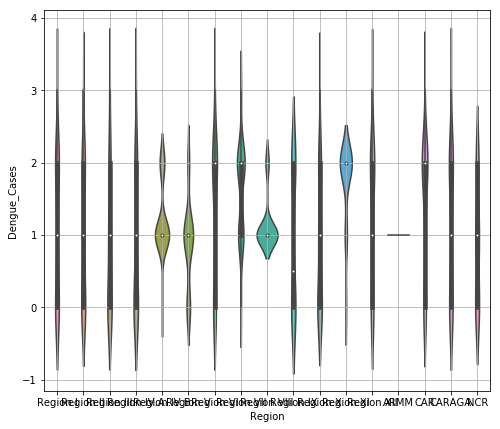

In [160]:
y_hat = pd.Series(sklr.predict(dengue_features))
errors = dengue_target[dengue_target != y_hat]

# y_hat.describe()
# display(y_hat)
display(errors.describe())

sns.violinplot(y=errors, x=dengue_df.Region)
plt.grid()

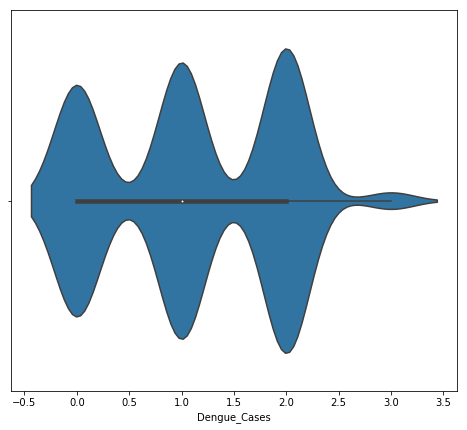

In [161]:
sns.violinplot(errors)

Index(['Month', 'Year', 'Region', 'Dengue_Cases'], dtype='object')


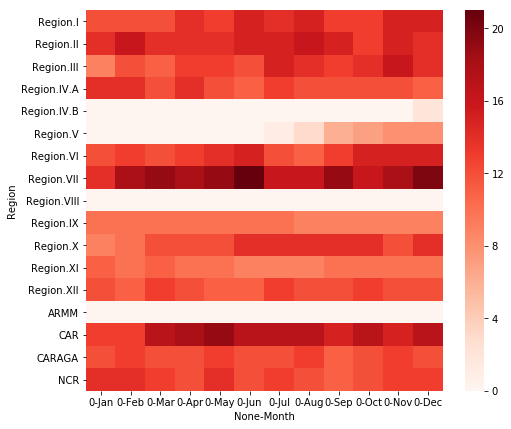

In [142]:
group_heatmap(dengue_df.drop('Dengue_Cases', axis=1), sklr.predict(dengue_features), 'Month')